# Temp. diffusion & open SideWalls

## Summary 

In this notebook we add temperature diffusion, and explore using different boundary conditions. Modelling temperature diffusion means we will now be evolving a mesh variable (temperatureField) rather than just advecting a swarm variable as in previous notebooks. This is prett simple, requiring that we:

* project the initial temperature structure (on the swarm var. ) onto the temperatureField mesh variable
* create an advectionDiffusion  system with appropriate boundary conditions. 
* connnect the bouyancy force and rheology laws to the temperatureField rather than the swarm




## Dev Notes


* If MOR lithostatic pressure tractions are applied at the sidewalls and bottom walls ($\sigma_{ij} \cdot n = 0$), the slab basically falls out the bottom. Once the slab leaves the bottom, the density dissapears, so $\vec{F}_{slab}$ reaches an equilibrium. Some trench advance occurs in the early part of the free sinking phase.  

* if only sidewalls are open, and the $\vec{V}_{x}$ is fixed to zero on a bottom edge node, the slab undergoes a significant trench advance in the early part of the free sinking phase. Is this an artifact of low resolution? Very much so. With higher resolution, the trench advance dissapears. The trench is then stationary until the salb encounters the lower mantle, after which a period of rollback occurs. However, the equilibrium dip appears to be vertical, and the trench tends to stationary. This appears to be true if we start with MORS at the sidewalls, or we simply have constant-width plates extending the sidewalls (like in Chertova)



## Imports

In [1]:
#use this block to point to a local version of UWsubduction
import sys

try:
    sys.path.append('..')
except:
    pass

In [2]:
import os
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import UWsubduction as usub

## Create output dir structure

In [3]:
#outputPath = os.path.join(os.path.abspath("."),"output/")
outputPath = os.path.join(os.path.abspath("."),"output/files")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.mpi.barrier()

## Parameters / Scaling

* For more information see, `UWsubduction/Background/scaling`


In [4]:
import UWsubduction.params as params 

#define some more concise names
ur = params.UnitRegistry
sca = params.sub_scaling
ndimlz = sca.nonDimensionalize
#build the dimensionless paramter / model dictionaries
ndp = params.build_nondim_dict(params.paramDict_dim  , sca)   
md = params.build_nondim_dict(params.modelDict_dim  , sca)

assert ndimlz(params.paramDict_dim.refLength) == 1.0

# changes to base params (for testing)
md.faultThickness *= 1.5 #15 km
md.res = 64
md.aspectRatio=4
md.depth *= 1.5
md.slabInitMaxDepth = 750/2900.
ndp.lowerMantleViscFac = 10.
ndp.yieldStressMax *= 0.75

/root/underworld2/unsupported/scaling/__init__.py:13: UserWarning: 

    The scaling module is not supported.

    It requires 'pint' as a dependency.

    You can install pint by running:

    'pip install pint' in a terminal

    Questions should be addressed to romain.beucher@unimelb.edu.au 
 
  Questions should be addressed to romain.beucher@unimelb.edu.au \n """


## Build / refine mesh, Stokes Variables

In [5]:
yres = int(md.res)
xres = int(md.res*6) 

halfWidth = 0.5*md.depth*md.aspectRatio 

minCoord_    = (-1.*halfWidth, 1. - md.depth) 
maxCoord_    = (halfWidth, 1.)

mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_) 

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) 
    

velocityField.data[:] = 0.
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [6]:
#mesh.reset() #call to reset mesh nodes to original locations

if md.refineHoriz:
    
    with mesh.deform_mesh():
        
        normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
        mesh.data[:,0] = mesh.data[:,0] * np.exp(md.meshRefineFactor*normXs**2) / np.exp(md.meshRefineFactor*1.0**2)    
    
if md.refineVert:

    with mesh.deform_mesh():
        
        mesh.data[:,1] = mesh.data[:,1] - 1.0

        normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
        mesh.data[:,1] = mesh.data[:,1] * np.exp(md.meshRefineFactor*normYs**2)/np.exp(md.meshRefineFactor*1.0**2)

        mesh.data[:,1] = mesh.data[:,1] + 1.0


In [7]:
#figMesh = glucifer.Figure()
#figMesh.append( glucifer.objects.Mesh(mesh)) 
#figMesh.show()
#figMesh.save_database('test.gldb')

In [8]:
#assert np.allclose(mesh.maxCoord[1], mesh.data[:,1].max())

## Build plate model (TectModel)

* For more information see, `UWsubduction/Background/tectModel`

In [9]:
endTime = ndimlz(30*ur.megayear) 
refVel = ndimlz(2*ur.cm/ur.year)
plateModelDt = ndimlz(0.1*ur.megayear)

In [10]:
#Create tectonic model, add plates
tm = usub.TectonicModel(mesh, 0, endTime, plateModelDt)
tm.add_plate(1, velocities=False)
tm.add_plate(2, velocities=False)

#add plate boundaries
tm.add_left_boundary(1, plateInitAge=md.slabAge, velocities=False)
tm.add_subzone(1, 2, md.subZoneLoc, subInitAge=md.slabAge, upperInitAge=md.opAgeAtTrench)
tm.add_right_boundary(2, plateInitAge=md.opAgeAtTrench, velocities=False)



## Build plate age / temperature Fns

In [11]:
pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, fnAge_map ))
#fig.show()

In [12]:
coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]

platethickness = 2.32*fn.math.sqrt(1.*fnAge_map )  

halfSpaceTemp = ndp.potentialTemp_*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))

plateTempProxFn = fn.branching.conditional( ((depthFn > platethickness, ndp.potentialTemp_ ), 
                                           (True,                      halfSpaceTemp)  ))



In [13]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, plateTempProxFn, onMesh = True))
#fig.show()

## Make swarm and Swarm Vars

In [14]:
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(md.ppc))
swarm.populate_using_layout( layout=layout ) # Now use it to populate.
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )

#
proxyTempVariable.data[:] = 1.0
proximityVariable.data[:] = 0.0
signedDistanceVariable.data[:] = 0.0


## Create tmUwMap

In [15]:
#Now we have built are primary FEM / Swarm objects, we collect some of these in a dictionary,
#to provide a consistent form to pass to methods of TectModel

tmUwMap = usub.tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)

## Make slab perturbation and subduction interface

* For more information see, `UWsubduction/Background/interface2D`


In [16]:
def circGradientFn(S):
    if S == 0.:
        return 0.
    elif S < md.radiusOfCurv:
        return max(-S/np.sqrt((md.radiusOfCurv**2 - S**2)), -1e3)
    else:
        return -1e5

def circGradientFn2(S):
    if S == 0.:
        return 0.
    elif S < 1.*md.radiusOfCurv:
        return max(-S/np.sqrt((md.radiusOfCurv**2 - S**2)), -3.)
    else:
        return -3.

def circGradientFn3(S):
    if S < 1.*md.radiusOfCurv:
        return circGradientFn2(S)
    else:
        return min(circGradientFn2(2.6*md.radiusOfCurv - S), -0.1)

In [17]:
#define fault particle spacing
ds = (tm.maxX - tm.minX)/(8.*tm.mesh.elementRes[0])

fCollection = usub.interface_collection([])

deepDepth = ndimlz(150.*ur.kilometer)

for e in tm.undirected.edges():
    if tm.is_subduction_boundary(e):
        usub.build_slab_distance(tm, e, circGradientFn3, md.slabInitMaxDepth, tmUwMap)
        fb = usub.build_fault(tm, e, circGradientFn3, md.faultThickness , md.slabInitMaxDepth, ds, md.faultThickness, tmUwMap)

        fCollection.append(fb)

#
usub.build_slab_temp(tmUwMap, ndp.potentialTemp_, md.slabAge)
fnJointTemp = fn.misc.min(proxyTempVariable,plateTempProxFn)

#And now reevaluate this guy on the swarm
proxyTempVariable.data[:] = fnJointTemp.evaluate(swarm)

In [18]:
#Finally, build the "proximity", i.e. the region immediately around the fault 

proximityVariable.data[:] = 0

for f in fCollection:
    f.rebuild()
    f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0)

In [19]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Points(swarm, proxyTempVariable))
#fig.show()
#fig.save_database('test.gldb')

In [20]:
#figProx = glucifer.Figure(figsize=(960,300) )
#figProx.append( glucifer.objects.Points(swarm , proximityVariable))
#figProx.append( glucifer.objects.Surface(mesh, mantleCreep, logScale=True))

#for f in fCollection:
#    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))

#figProx.show()


#figProx.save_database('test.gldb')

##  Define subduction fault evolution (rebuild/destroy)


In this section we setup some functions to help manage the spatial distribution of faults

In [21]:
# Setup a swarm to define the replacment positions
fThick= fCollection[0].thickness

faultloc = 1. - md.faultThickness*md.faultLocFac

allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys

#*faultRmfn describes the regions where we well remove the interface2D swarms , 
#We also remove interface2Dswarms particles beneath a given depth

faultRmfn = tm.t2f(tm.variable_boundary_mask_fn(distMax=10., distMin=ndimlz(10*ur.km), relativeWidth = 0.9, 
                                  minPlateLength =ndimlz(60*ur.km),  
                                           out = 'bool', boundtypes='sub' ))




#* faultAddFn desribes a region internal to the subducting plate where we rebuild the fault. 
#this function deliberately'over-builds' the fault, while remove_faults_from_boundaries then trims it to size

#this one will put particles back into the fault
faultAddFn1 = tm.variable_boundary_mask_fn(distMax=10., distMin=ndimlz(10*ur.km), 
                                       relativeWidth = 0.95, minPlateLength =ndimlz(60*ur.km),  
                                           out = 'bool', boundtypes='sub' )

#thsi will keep the fault addition away from the subdcution zone
faultAddFn2 =  tm.t2f(tm.variable_boundary_mask_fn(distMax = ndimlz(150*ur.km), relativeWidth = 0.9 ))

faultAddFn = operator.and_( faultAddFn1 ,  faultAddFn2)



#The order these functions are run needs to be preserved,
dummy = usub.remove_fault_drift(fCollection, faultloc)
dummy = usub.pop_or_perish(tm, fCollection, faultMasterSwarm, faultAddFn , ds)
dummy = usub.remove_faults_from_boundaries(tm, fCollection, faultRmfn )

In [22]:
#maskFn_ = tm.t2f(faultRmfn)
#pIdFn = tm.plate_id_fn(maskFn=maskFn_)

In [23]:
#fig = glucifer.Figure(figsize=(600, 300))
#fig.append( glucifer.objects.Surface(tm.mesh, faultRmfn , onMesh=True))
#fig.show()

## Project the swarm 'proxy temp' to mesh

In [24]:
projectorMeshTemp= uw.utils.MeshVariable_Projection( temperatureField, proxyTempVariable , type=0 )
projectorMeshTemp.solve()

In [25]:
#figTemp = glucifer.Figure()
#figTemp.append( glucifer.objects.Surface(mesh, temperatureField, onMesh=True, colourBar=False))
#figTemp.append( glucifer.objects.Contours(mesh, temperatureField,interval=0.33, 
#                                          colours='black', colourBar=False, quality=3))
#figTemp.show()
#figTemp.save_database('test.gldb')

## Boundary conditions

In [26]:
appliedTractionField = uw.mesh.MeshVariable( mesh=mesh,    nodeDofCount=2 )

In [27]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]


In [88]:
pressureDiff = ndimlz(5*ur.megapascal)

plateThermalTaper = usub.cosine_taper(temperatureField, 0.9, 0.01)
platePressureFn = (1. - plateThermalTaper)*params.rayleighNumber*depthFn
pressMinMax = fn.view.min_max(platePressureFn)
ignore = pressMinMax.evaluate(lWalls)
lhsPressMax = pressMinMax.max_global()
pressMinMax.reset()
ignore = pressMinMax.evaluate(rWalls)
rhsPressMax = pressMinMax.max_global()
lhsPressMax, rhsPressMax

lhsPressFn = -1.*platePressureFn + -1.*plateThermalTaper*(max(lhsPressMax, rhsPressMax )) + 0.5*pressureDiff
rhsPressFn = platePressureFn + plateThermalTaper*(max(lhsPressMax, rhsPressMax )) + 0.5*pressureDiff

In [91]:
#plt.plot(rhsPressFn.evaluate(rWalls) + lhsPressFn.evaluate(lWalls) )
#plt.plot(rhsPressFn.evaluate(rWalls))
#plt.plot(lhsPressFn.evaluate(lWalls))

In [55]:
#umTaper = (1. - usub.cosine_taper(depthFn, md.lowerMantleDepth, ndimlz(50*ur.kilometer) ))
#plateLambda = 0.9
#platethickness = plateLambda*2.32*np.math.sqrt(1.*md.slabAge) #redefining a var (uw Fn) we no longer need
#lithTaper = usub.cosine_taper(depthFn, platethickness, ndimlz(20*ur.kilometer) )
#pressureFn = 0.5*(lithTaper*umTaper)*pressureDiff

In [56]:
#fig = glucifer.Figure()
#fig.append( glucifer.objects.Surface(mesh, platePressureFn , onMesh=True))
#fig.show()

In [63]:


if lWalls.data.shape[0]:
    appliedTractionField.data[[lWalls.data]]=  np.column_stack((lhsPressFn.evaluate(lWalls), 
                                                            np.zeros(len(lWalls.data)) ))

#because of the sign, this acts as a negative pressure, trying to push material out of the domain
if rWalls.data.shape[0]:
    appliedTractionField.data[[rWalls.data]]=  np.column_stack((rhsPressFn.evaluate(rWalls),
                                                                np.zeros(len(rWalls.data)) ))
  



#pressureGrad = fn.misc.constant(0.)
#lithPressureFn = depthFn * pressureGrad
#if lWalls.data.shape[0]:
#    appliedTractionField.data[[lWalls.data]]=  np.column_stack((lithPressureFn.evaluate(lWalls), 
#                                                            np.zeros(len(lWalls.data)) ))
#if rWalls.data.shape[0]:
#    appliedTractionField.data[[rWalls.data]]=  np.column_stack((-1*lithPressureFn.evaluate(rWalls), 
#                                                            np.zeros(len(rWalls.data)) ))


In [64]:
vxId = bWalls & rWalls 
fixedVxNodes  = mesh.specialSets["Empty"]
fixedVxNodes  += vxId

########
#For open Sidewalls
########

velBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (fixedVxNodes, jWalls + iWalls) )

r_sub = rWalls - bWalls

nbc = uw.conditions.NeumannCondition( fn_flux=appliedTractionField, 
                                      variable=velocityField,
                                      indexSetsPerDof=(lWalls + r_sub, None ) )

In [65]:
#Ridges Temp not enforced
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )



## Reassert the tempBCS
temperatureField.data[tWalls.data] = 0.0
temperatureField.data[bWalls.data] = 1.0


#Alternatively, uncomment these to enforce thermal ridges at the sidewalls

#dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
#                                              indexSetsPerDof=(tWalls + iWalls,) )


###If we want thermal ridges fixed
#temperatureField.data[iWalls.data] = 1.

In [66]:
## set up some swarms to track the boundary velocity

lWallsSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=False)
rWallsSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=False)
bWallsSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=False)

dummy = lWallsSwarm.add_particles_with_coordinates(mesh.data[lWalls.data])
dummy = rWallsSwarm.add_particles_with_coordinates(mesh.data[rWalls.data])
dummy = bWallsSwarm.add_particles_with_coordinates(mesh.data[bWalls.data])

lWallsVn = uw.swarm.SwarmVariable(lWallsSwarm, 'double', 1)
rWallsVn = uw.swarm.SwarmVariable(rWallsSwarm, 'double', 1)
bWallsVn = uw.swarm.SwarmVariable(bWallsSwarm, 'double', 1)

In [67]:
def track_boundary_vels():
    
    lWallsVn.data[:] = velocityField[0].evaluate(lWalls)
    lWallsVn.save('output/' + "lWallsVn_" + str(step).zfill(3) + "_.h5")
    
    rWallsVn.data[:] = velocityField[0].evaluate(rWalls)
    rWallsVn.save('output/' + "rWallsVn_" + str(step).zfill(3) + "_.h5")
    
    bWallsVn.data[:] = velocityField[1].evaluate(bWalls)
    bWallsVn.save('output/' + "bWallsVn_" + str(step).zfill(3) + "_.h5")

In [92]:
#track_boundary_vels()
#!ls output
#md.buoyancyFac

1.0

## Buoyancy

In [325]:
temperatureFn = temperatureField

# Now create a buoyancy force vector using the density and the vertical unit vector. 
#thermalDensityFn = ndp.rayleigh*(1. - proxyTempVariable)
thermalDensityFn = md.buoyancyFac*params.rayleighNumber*(1. - temperatureFn)



gravity = ( 0.0, -1.0 )

buoyancyMapFn = thermalDensityFn*gravity

In [326]:
#update_boundary_pressure()

## Rheology

In [327]:
symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )

#Set up any functions required by the rheology
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=md.viscosityMin, viscmax=md.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [165]:
#Interface rheology extent

subZoneDistfn = tm.subZoneAbsDistFn(upper=True)


faultHorizTaperFn  = usub.cosine_taper(subZoneDistfn, 
                                  md.faultViscHorizTaperStart, md.faultViscHorizTaperWidth)
faultDepthTaperFn = usub.cosine_taper(depthFn, 
                                 md.faultViscDepthTaperStart, md.faultViscDepthTaperWidth)

In [167]:
adiabaticCorrectFn = depthFn*ndp.adiabaticTempGrad
dynamicPressureProxyDepthFn = pressureField/params.pressureDepthGrad
druckerDepthFn = fn.misc.max(0.0, depthFn + md.druckerAlpha*(dynamicPressureProxyDepthFn))

#Diffusion Creep
diffusionUM = (1./ndp.diffusionPreExp)*\
    fn.math.exp( ((ndp.diffusionEnergyDepth + \
                   (depthFn*ndp.diffusionVolumeDepth))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

#diffusionUM =     safe_visc(diffusionUM)
    
diffusionLM = ndp.lowerMantleViscFac*(1./ndp.diffusionPreExp)*\
    fn.math.exp( ((ndp.diffusionEnergyDepth + \
                   (depthFn*ndp.diffusionVolumeDepth))/((temperatureFn+ adiabaticCorrectFn + ndp.surfaceTemp))))

#diffusionLM =     safe_visc(diffusionLM)


transitionZoneTaperFn = usub.cosine_taper(depthFn, md.lowerMantleDepth - 0.5*md.lowerMantleTransWidth , md.lowerMantleTransWidth )


mantleCreep = diffusionUM*(1. - transitionZoneTaperFn) + transitionZoneTaperFn*diffusionLM

#Define the mantle Plasticity
ys =  ndp.cohesionMantle + (druckerDepthFn*ndp.frictionMantleDepth)
ysf = fn.misc.min(ys, ndp.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 

mantleRheologyFn =  safe_visc(mantleCreep*yielding/(mantleCreep + yielding), 
                              viscmin=md.viscosityMin, viscmax=md.viscosityMax)


faultViscosityFn = ndp.viscosityFault

faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +  \
                       faultDepthTaperFn*mantleRheologyFn + faultHorizTaperFn*mantleRheologyFn

In [168]:
#create a mapping dictionary that points proximity variable to fault rheology
viscMapDict = {}
viscMapDict[0] = mantleRheologyFn
for f in fCollection:
    viscMapDict[f.ID] = faultRheologyFn
viscMapDict

viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = viscMapDict)

In [169]:
#fig = glucifer.Figure(figsize=(960,300) )
#fig.append( glucifer.objects.Surface(mesh, faultRheologyFn))
#fig.show()

## Stokes

In [170]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)

NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)

def smooth_pressure(mesh):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.

    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later
def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh)

In [171]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC, nbc],
                                   #conditions     = [velBC, ],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn )


In [172]:
solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4


In [173]:
solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)
solver.print_stats()


 
Pressure iterations:   4
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 2.8328e-01
Pressure solve time: 3.6300e-02
Velocity solve time: 2.8209e-01 (backsolve)
Total solve time   : 6.4995e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



## Advection - Diffusion

In [42]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureFn, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = ndp.refDiffusivity, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

## Swarm Advector

In [43]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


In [44]:
population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, 
                                                splitThreshold=0.25,maxDeletions=1, maxSplits=3, aggressive=True,
                                                aggressiveThreshold=0.9, particlesPerCell=int(md.ppc))

## Update functions

In [45]:
valuesDict = edict({})
valuesDict.timeAtSave = []
valuesDict.stepAtSave = []
for e in tm.undirected.edges():
    valuesDict[str(e)] = []
valuesDict  

{'(1, 1)': [], '(1, 2)': [], '(2, 2)': [], 'stepAtSave': [], 'timeAtSave': []}

In [46]:
# Here we'll handle everything that should be advected - i.e. every timestep
def advect_update(dt):
    # Retrieve the maximum possible timestep for the advection system.
    #dt = advector.get_max_dt()
    # Advect swarm
    advector.integrate(dt)
    
    #Advect faults
    for f in fCollection:
        f.advection(dt)
    
    
    return time+dt, step+1

In [47]:
#velocityField.data[:] = 0.
#pressureField.data[:] = 0.
#ndp.interfaceViscEndWidth*2900

In [48]:
def update_faults():
    
    
    #order is very important here
    dummy = usub.remove_fault_drift(fCollection, faultloc)
    dummy = usub.pop_or_perish(tm, fCollection, faultMasterSwarm, faultAddFn , ds)
    dummy = usub.remove_faults_from_boundaries(tm, fCollection, faultRmfn )
    
    for f in fCollection:
        
        #Remove particles below a specified depth
        depthMask = f.swarm.particleCoordinates.data[:,1] <         (1. - md.faultDestroyDepth)
        with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[depthMask] = (9999999., 9999999.)
        
        #The repair_interface2D routine is supposed to maintain particle density and smooth
        usub.interfaces.repair_interface2D(f, ds, k=8)
    

In [50]:
def update_swarm():
    

    for f in fCollection:
        f.rebuild()
        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0,
                                maxDistanceFn=fn.misc.constant(2.))
        
    #A simple depth cutoff for proximity
    depthMask = swarm.particleCoordinates.data[:,1] < (1. - md.faultDestroyDepth)
    proximityVariable.data[depthMask] = 0
    

In [53]:
def update_tect_model(tectModel, tmUwMap, time, dt = 0.0 ):
    
    """
    An example of how we can update the tect_model
    """
    for e in tectModel.undirected.edges():
        
        #This is generally the first condition to check" a specified boundary velocity
        if tectModel.bound_has_vel(e, time):
            newX = get_boundary_vel_update(tectModel, e, time, dt)
            tectModel.set_bound_loc(e, newX)
            
        #in this model the ficticious boundaries remain fixed at the edge
        elif e[0] == e[1]:
            pass       
        #now we'll apply a strain rate query to update the subduction zone loc
        elif tectModel.is_subduction_boundary(e):
            e = tectModel.subduction_edge_order(e)
            newx = usub.strain_rate_field_update(tectModel, e, tmUwMap, dist = ndimlz(100*ur.kilometer))
            tectModel.set_bound_loc(e, newx)
        else:
            pass


In [55]:
#update_tect_model(tm, tmUwMap, time=0.1, dt = 1e-6)

In [56]:
def update_mask_fns():

    faultRmfn = tm.t2f(tm.variable_boundary_mask_fn(distMax=10., distMin=ndimlz(10*ur.kilometer), relativeWidth = 0.9, 
                                      minPlateLength =ndimlz(60*ur.kilometer),  
                                               out = 'bool', boundtypes='sub' ))
    


    #this one will put particles back into the fault
    faultAddFn1 = tm.variable_boundary_mask_fn(distMax=10., distMin=ndimlz(10*ur.kilometer), 
                                           relativeWidth = 0.95, minPlateLength =ndimlz(60*ur.kilometer),  
                                               out = 'bool', boundtypes='sub' )

    faultAddFn2 =  tm.t2f(tm.variable_boundary_mask_fn(distMax = ndimlz(100*ur.kilometer), relativeWidth = 0.9 ))


    faultAddFn = operator.and_( faultAddFn1 ,  faultAddFn2)

    
    #the following dictates where the fault rheology will be activated
    subZoneDistfn = tm.subZoneAbsDistFn(upper=True)
    
    faultHorizTaperFn  = usub.cosine_taper(subZoneDistfn, 
                                  md.faultViscHorizTaperStart, md.faultViscHorizTaperWidth)
    
    return faultRmfn, faultAddFn, faultHorizTaperFn

In [57]:
## Track the values of the plate bounaries

  
def update_values():
    
    """ 
    Assumes global variables:
    * valuesDict
    * time
    * step 
    ...
    + many functions
    """
    
    
    #save the time and step
    valuesDict.timeAtSave.append(time) 
    valuesDict.stepAtSave.append(step)
    
    for e in tm.undirected.edges():
        if tm.is_subduction_boundary(e):
            ee = tm.subduction_edge_order(e) #hacky workaround for the directed/ undireted. need get_bound_loc
        else:
            ee = e

        valuesDict[str(e)].append(tm.get_bound_loc(ee))
        
        
    #save
    if uw.rank()==0:
        fullpath = os.path.join(outputPath + "tect_model_data")
        #the '**' is important
        np.savez(fullpath, **valuesDict)
    

In [58]:
#update_values()
#valuesDict  
#!ls output


## Viz

In [ ]:
viscSwarmVar =  swarm.add_variable( dataType="double", count=1 )
viscSwarmVar.data[:] = viscosityMapFn.evaluate(swarm)

In [206]:
store1 = glucifer.Store('output/subduction1')
store2 = glucifer.Store('output/subduction2')
store3 = glucifer.Store('output/subduction3')
store4 = glucifer.Store('output/subduction4')


figTemp = glucifer.Figure(store1, figsize=(960,300) )
figTemp.append( glucifer.objects.Surface(mesh, temperatureField, onMesh=True))
figTemp.append( glucifer.objects.Contours(mesh, temperatureField, resolution=300, quality =4, interval=0.2,  colours='Black', colourBar=False)) 


figVisc = glucifer.Figure( store2, figsize=(960,300) )
#figVisc.append( glucifer.objects.Points(swarm, viscosityMapFn, pointSize=2, logScale=True) )
figVisc.append( glucifer.objects.Points(swarm,  viscSwarmVar, logScale=True, valueRange = [0.1, 1e4]) )



figVel = glucifer.Figure( store3, figsize=(960,300) )
figVel.append(glucifer.objects.Surface(mesh, fn.math.dot(velocityField, velocityField), onMesh=True))
figVel.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=1./refVel) )

figProx = glucifer.Figure(store4, figsize=(960,300) )
figProx.append( glucifer.objects.Points(swarm , proximityVariable))
for f in fCollection:
    figProx.append( glucifer.objects.Points(f.swarm, pointSize=5))


#figMask.append( glucifer.objects.Surface(mesh,  maskFnVar3) )
for f in fCollection:
    figVel.append( glucifer.objects.Points(f.swarm, pointSize=5))



NameError: name 'viscSwarmVar' is not defined


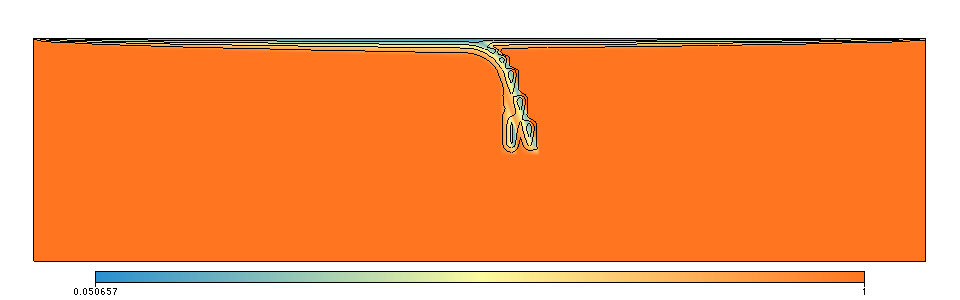

In [176]:
#figTemp.show()
#figVisc.save_database('test.gldb')

In [78]:
#1e-2*2900.

## Main Loop

In [185]:
time = 0.  # Initial time
step = 0 
maxSteps = 1000      # Maximum timesteps 
steps_output = 2    # output (Viz/Values) every N timesteps
swarm_update = 5     # repopulate and update swarm proximity
faults_update = 2   # rebuild, truncate repair_interface2D
dt_model = 0.
steps_update_model = 2
update_pressure = 10

update_values()

NameError: name 'update_values' is not defined

In [110]:
#step

In [50]:
while time < tm.times[-1] and step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True, nonLinearTolerance=md.nltol, callback_post_solve = pressure_calibrate)

    dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    
    #advect swarm and faults
    time, step =  advect_update(dt)
    dt_model += dt
    
        
    #update tectonic model and associated mask functions
    if step % steps_update_model == 0:
        update_tect_model(tm, tmUwMap, time, dt = dt_model)
        dt_model = 0.
        
        plate_id_fn = tm.plate_id_fn()
        faultRmfn, faultAddFn, faultHorizTaperFn = update_mask_fns()
        
        #these need to be explicity updated
        faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +\
        faultDepthTaperFn*mantleRheologyFn + faultHorizTaperFn*mantleRheologyFn
        
        viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        1:faultRheologyFn} )

        
        
    #running fault healing/addition, map back to swarm
    if step % faults_update == 0:
        update_faults()
    if step % swarm_update == 0:
        population_control.repopulate()
        update_swarm()
        
        
    #rebuild stokes - if boundary conditions are changing
    #if step % steps_update_model == 0:
    #    del solver
    #    del stokes
    #    stokes = update_stokes(time, viscosityMapFn )
    #    solver = rebuild_solver(stokes)
        
    
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        update_values()
        
        #also update this guy for viz
        viscSwarmVar.data[:] = viscosityMapFn.evaluate(swarm)
        
        #Important to set the timestep for the store object here or will overwrite previous step
        store1.step = step
        store2.step = step
        store3.step = step
        store4.step = step
        
        figTemp.save(    outputPath + "temp"    + str(step).zfill(4))
        figVisc.save(    outputPath + "visc"    + str(step).zfill(4))
        figVel.save(    outputPath + "vel"    + str(step).zfill(4))
        figProx.save(    outputPath + "prox"    + str(step).zfill(4))
        #save out the surface velocity
        #save_files(step)
    
    if uw.rank()==0:
        print 'step = {0:6d}; time = {1:.3e}'.format(step,time)


NameError: name 'step' is not defined

## Scratch

array([  1.05918286e+02,   7.57092124e+01,   5.11800354e+01,
         2.99776473e+01,   1.21626099e+01,  -3.14463019e+00,
        -1.59976897e+01,  -2.69620607e+01,  -3.60988749e+01,
        -4.38224302e+01,  -5.01894984e+01,  -5.55260741e+01,
        -5.98805940e+01,  -6.35146873e+01,  -6.64570614e+01,
        -6.89051669e+01,  -7.08666343e+01,  -6.42706469e+01,
         2.59821399e+02,   5.51173307e+02,   8.26319511e+02,
         1.09046830e+03,   1.34671269e+03,   1.59618271e+03,
         1.83929363e+03,   2.07558630e+03,   2.30419447e+03,
         2.52362955e+03,   2.73198465e+03,   2.92668949e+03,
         3.10447720e+03,   3.26108875e+03,   3.39079961e+03,
         3.48598431e+03,   3.53553893e+03,   3.52392386e+03,
         3.42629479e+03,   3.20507802e+03,   2.79302699e+03,
         2.07475728e+03,   8.08304228e+02,  -1.56433362e+03,
        -5.93304210e+03,  -1.10779219e+04,  -1.50734446e+04,
        -1.52387358e+04,  -6.18838250e+03,   8.20586139e+02,
         8.91266471e+02]

In [289]:
#%pylab inline
#fig, ax = plt.subplots()
#ax.plot(  appliedTractionField.evaluate(rWalls)[:,0], depthFn.evaluate(lWalls)*2900)
#ax.set_ylim(1500, -10)
#update_boundary_pressure()

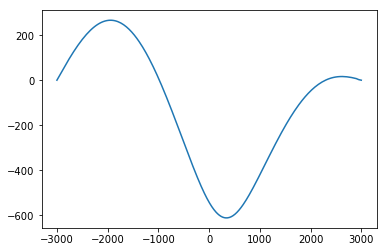

In [189]:
#fig, ax = plt.subplots()
#ax.plot(  coordinate[0].evaluate(bWalls)*2900, velocityField.data[bWalls.data][:,1] )

In [ ]:
##some stuff I was working on try to get stress boundary condition on sides + bottom


#setup density integral

densIntegral = uw.utils.Integral(thermalDensityFn, mesh, integrationType='volume')
densIntegralVal = densIntegral.evaluate()[0]

#platethickness = 2.32*np.math.sqrt(1.*md.slabAge) #redefining a var (uw Fn) we no longer need
platethickness = 0. #redefining a var (uw Fn) we no longer need


plateRegionFn = depthFn < platethickness
plateRegionFn = tm.b2f(plateRegionFn)


plateDensIntegral = uw.utils.Integral(plateRegionFn*thermalDensityFn, mesh, integrationType='volume')
plateDensIntegralVal = plateDensIntegral.evaluate()[0]



vxId2 = lWalls & bWalls 
fixedVxNodes2  = mesh.specialSets["Empty"]
fixedVxNodes2  += vxId2

def update_boundary_pressure():

    totWidth = (mesh.maxCoord[0] - mesh.minCoord[0])
    totDepth = (mesh.maxCoord[1] - mesh.minCoord[1])
    totVolume = totWidth*totDepth


    densIntegralVal = densIntegral.evaluate()[0]
    platedensIntegralVal = plateDensIntegral.evaluate()[0]
    baseAveragePressureVal = (densIntegralVal/(totVolume))/(mesh.maxCoord[0] - mesh.minCoord[0])
    baseAveragePressureFn = fn.misc.constant(baseAveragePressureVal)

    #apply to base

    if bWalls.data.shape[0]:
        appliedTractionField.data[[bWalls.data]]=  np.column_stack(( np.zeros(len(bWalls.data))  , 
                                                                baseAveragePressureFn.evaluate(bWalls) ) )

    #apply to sides
    plateDensFac = platedensIntegralVal/densIntegralVal

    plateSidePressFn = baseAveragePressureVal*plateDensFac*(depthFn/platethickness)

    mantleSidePressFn  = baseAveragePressureVal*plateDensFac +  \
                         (1. - plateDensFac)*baseAveragePressureVal*((depthFn - platethickness)/(totDepth -  platethickness))

    #sidePressFn =  fn.branching.conditional( ((depthFn < platethickness, plateSidePressFn ), 
    #                                           (True,                      mantleSidePressFn)  ))
    
    sidePressFn = baseAveragePressureFn
    
    if lWalls.data.shape[0]:
        appliedTractionField.data[[lWalls.data]]=  np.column_stack((sidePressFn.evaluate(lWalls), 
                                                            np.zeros(len(lWalls.data)) ))
    if rWalls.data.shape[0]:
        appliedTractionField.data[[rWalls.data]]=  np.column_stack((-1*sidePressFn.evaluate(rWalls), 
                                                                np.zeros(len(rWalls.data)) ))
        
    
    #fix the bottom LHS corner
    
    appliedTractionField.data[[fixedVxNodes2.data]] = (baseAveragePressureVal, baseAveragePressureVal)
    appliedTractionField.data[[fixedVxNodes2.data]] 

In [85]:
#%pylab inline